# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [140]:
# Load pickled data

import pickle
import os

# training and testing data
pwd = os.path.dirname(os.path.abspath('__file__'))
training_file = pwd + "/traffic-signs-data/train.p"
testing_file = pwd + "/traffic-signs-data/test.p"


with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_test, y_test = test['features'], test['labels']

In [141]:
### To start off let's do a basic data summary.

import numpy as np

# TODO: number of training examples
n_train = len(x_train)

# TODO: number of testing examples
n_test = len(x_test)

# TODO: what's the shape of an image?
image_shape = x_train[0].shape[0:2]

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


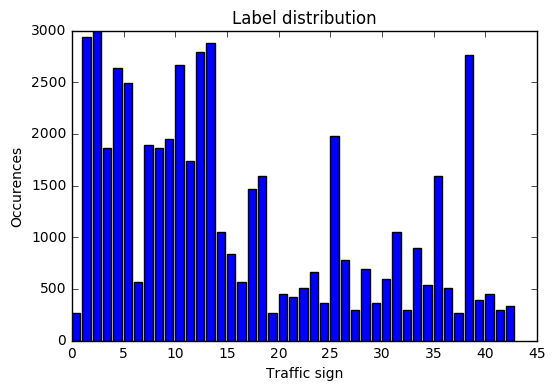

In [142]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import collections
import matplotlib.pyplot as plt

#---------------------------------
#distribution of classes
all_y = np.concatenate((y_train, y_test))

label_dist = collections.Counter(all_y)

labels, vals = zip(*label_dist.items())
indices = np.arange(len(labels))

plt.bar(indices, vals)
plt.title("Label distribution")
plt.ylabel("Occurences")
plt.xlabel("Traffic sign")
plt.show()


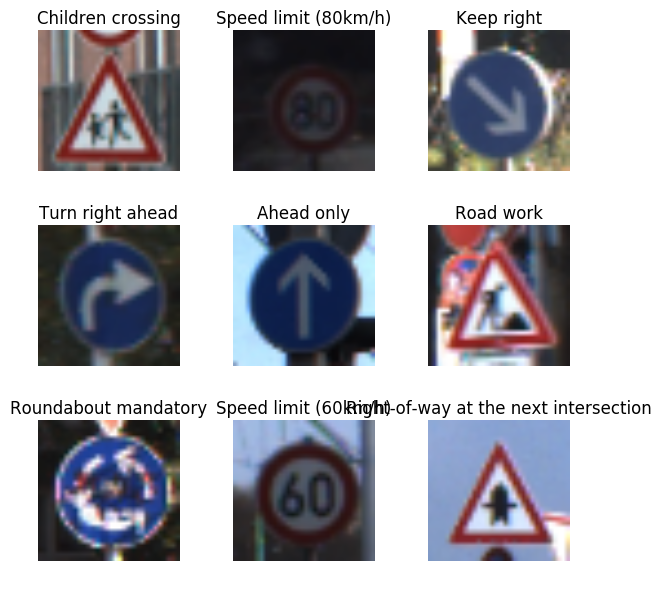

In [143]:
#look at some random traffic signs

#function to create dictionary that pairs sign ids with sign names
def signs_dict():
    names = open("signnames.csv").readlines()[1:]
    stripped = [name.strip().split(",") for name in names]
    return dict([(int(id), name) for id, name in stripped])

#create dict
signs_dict = signs_dict()

#gets images and labels for 9 random signs
rand_sign_indices = np.random.randint(0, n_train, 9)
rand_signs = x_train[rand_sign_indices] 
rand_labels = list(map(signs_dict.get, y_train[rand_sign_indices]))

#create plot
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))
axes = axes.ravel()
fig.tight_layout()
for ax, img, label in zip(axes, rand_signs, rand_labels):
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

#show plot
plt.show()


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [144]:
import cv2
from sklearn import preprocessing

#normalizing function to get 0-1 range and 0 variance
def normalize(img):
    normalized_img = cv2.normalize(img, None, 0.0, 0.1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return normalized_img

#blur function to increase
def gaussian_blur(img):
    """Applies a Gaussian Noise kernel"""
    kernel_size = 3
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

#shuffle training data
def randomize(features, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_features = features[permutation,:,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_features, shuffled_labels

x_train, y_train = randomize(x_train, y_train)

#apply preprocessing functions
x_train_processed = np.empty((len(x_train), image_shape[0], image_shape[1], 3))
x_test_processed = np.empty((len(x_test), image_shape[0], image_shape[1], 3))
for i in range(len(x_train)):
    x_train_processed[i] = normalize(gaussian_blur(x_train[i]))
for i in range(len(x_test)):
    x_test_processed[i] = normalize(gaussian_blur(x_test[i]))
    

#one hot encoding (change y dim to (obs, label))
#also change to float32, so it can be multiplied against the features in tf, which are float32
encoder = preprocessing.LabelBinarizer()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train).astype(np.float32)
y_test_encoded = encoder.transform(y_test).astype(np.float32)





### Question 1 

_Describe the techniques used to preprocess the data._

I used multiple techniques to preprocess the data.

I normalized such all values fall between 0 and 1. This is done due to numerical stability and computational efficiency. Then I applied a slight gaussian blur to reduce overfitting. Then I shuffled the training data. Finally, I one-hot-encoded the labels so that they work with tensorflow. 

In [145]:
#createing train, test, and validation sets
from sklearn.model_selection import train_test_split

x_test_2, x_valid_2, y_test_2, y_valid_2 = train_test_split(x_test_processed, y_test_encoded, test_size = 0.5, random_state = 0)

#renaming training sets to match
x_train_2 = x_train_processed
y_train_2 = y_train_encoded


print("X train: " + str(len(x_train_2)))
print("Y train: " + str(len(y_train_2)))

print("X valid: " + str(len(x_valid_2)))
print("Y valid: " + str(len(y_valid_2)))

print("X test: " + str(len(x_test_2)))
print("Y test: " + str(len(y_test_2)))





X train: 39209
Y train: 39209
X valid: 6315
Y valid: 6315
X test: 6315
Y test: 6315


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

I kept the training data the same size because it makes up around 75% of the total data. This is a good fraction - it is typical to use most of your data on training. 

I then randomized the testing data and split it into 2 equal parts - a new testing data set and a validation set.

In [146]:
### Define your architecture here.

#import libraries
import tensorflow as tf

#params
learning_rate = 0.0001
batch_size = 128
training_epochs = 100
n_classes = 43
filter_size = 5
dropout = 0.9

#graph input
x = tf.placeholder("float", [None, 32, 32, 3])
y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

#layer widths
layer_width = {
    'layer_1': 32,
    'layer_2': 64,
    'layer_3': 128,
    'fully_connected': 512
}

#conv wrapper
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

#pooling wrapper
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1,k,k,1],strides=[1,k,k,1],padding='SAME')


#weights and biases
weights = {
    'layer_1': tf.Variable(tf.truncated_normal(
        [filter_size, filter_size, 3, layer_width['layer_1']])),
    'layer_2': tf.Variable(tf.truncated_normal(
        [filter_size, filter_size, layer_width['layer_1'], layer_width['layer_2']])),
    'layer_3': tf.Variable(tf.truncated_normal(
        [filter_size, filter_size, layer_width['layer_2'], layer_width['layer_3']])),
    'fully_connected': tf.Variable(tf.truncated_normal(
        [4*4*128, layer_width['fully_connected']])),
    'out': tf.Variable(tf.truncated_normal(
            [layer_width['fully_connected'], n_classes]))
}


biases = {
    'layer_1': tf.Variable(tf.zeros(layer_width['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_width['layer_2'])),
    'layer_3': tf.Variable(tf.zeros(layer_width['layer_3'])),
    'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected'])),
    'out': tf.Variable(tf.zeros(n_classes))
}


#model
def conv_net(x, weights, biases, dropout):
    #layer 1 - 32*32*3 to 16*16*32
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    conv1 = maxpool2d(conv1)
    
    #layer 2 - 16*16*32 to 8*8*64
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    conv2 = maxpool2d(conv2)
    
    #layer 3 - 8*8*32 to 4*4*128
    conv3 = conv2d(conv2, weights['layer_3'], biases['layer_3'])
    conv3 = maxpool2d(conv3)
    
    #fully connected - 4*4*128 to 512
    #reshape first
    fc1 = tf.reshape(conv3,[-1,weights['fully_connected'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['fully_connected']),biases['fully_connected'])
    fc1 = tf.nn.tanh(fc1)
    
    #apply dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    
    #output layer - 512 to 43
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out
    
    
    

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
#construct model
logits = conv_net(x, weights, biases, keep_prob)

#loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)\
    .minimize(cost)
    
#evaluate model
prediction=tf.argmax(logits,1)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

#run session
sess = tf.Session()
sess.run(tf.initialize_all_variables())

#training cycle
for epoch in range(training_epochs):
    for offset in range(0, len(x_train_2), batch_size):
        
        # Get a batch of training features and labels
        end = offset + batch_size
        batch_features = x_train_2[offset:end]
        batch_labels = y_train_2[offset:end]

        # Run optimization op (backprop) and cost op (to get loss value)
        sess.run(optimizer, feed_dict={x: batch_features, y: batch_labels, keep_prob: dropout})

        # Display logs per epoch step
        loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_features, y: batch_labels, keep_prob: 1.})
        print("Epoch:", epoch, "Offset:", offset, "Loss:", loss, "Accuracy:", acc)


print("Optimization Finished!")
print("Accuracy:", sess.run(accuracy, feed_dict={x: x_test_2, y:y_test_2, keep_prob:1.}))



    





Epoch: 0 Offset: 0 Loss: 32.7038 Accuracy: 0.0390625
Epoch: 0 Offset: 128 Loss: 33.9507 Accuracy: 0.015625
Epoch: 0 Offset: 256 Loss: 34.4966 Accuracy: 0.0546875
Epoch: 0 Offset: 384 Loss: 31.1913 Accuracy: 0.046875
Epoch: 0 Offset: 512 Loss: 31.8703 Accuracy: 0.0546875
Epoch: 0 Offset: 640 Loss: 33.0611 Accuracy: 0.015625
Epoch: 0 Offset: 768 Loss: 34.4527 Accuracy: 0.03125
Epoch: 0 Offset: 896 Loss: 32.9988 Accuracy: 0.03125
Epoch: 0 Offset: 1024 Loss: 35.287 Accuracy: 0.015625
Epoch: 0 Offset: 1152 Loss: 32.9712 Accuracy: 0.0625
Epoch: 0 Offset: 1280 Loss: 32.5212 Accuracy: 0.03125
Epoch: 0 Offset: 1408 Loss: 34.2015 Accuracy: 0.0234375
Epoch: 0 Offset: 1536 Loss: 34.6121 Accuracy: 0.046875
Epoch: 0 Offset: 1664 Loss: 32.9822 Accuracy: 0.03125
Epoch: 0 Offset: 1792 Loss: 30.7359 Accuracy: 0.0546875
Epoch: 0 Offset: 1920 Loss: 30.6813 Accuracy: 0.046875
Epoch: 0 Offset: 2048 Loss: 32.0768 Accuracy: 0.0234375
Epoch: 0 Offset: 2176 Loss: 30.195 Accuracy: 0.0234375
Epoch: 0 Offset: 2304

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used a model similar to the one used in the convolutional neural network lesson. It has 3 hidden layers, which each have a convolution and max pooling step. Finally, there is a fully connected layer.

I used 100 epochs, a batch size of 128, a 5x5 filter size, and a 0.001 learning rate.

I also incorporated dropout to improve generalizability.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

I started with a simple neural network and added complexity when it lead to increases in testing accuracy. Once the overall architecture worked well, I experimented with the hyper parameters to come up with an optimal solution. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [152]:
#libraries
import scipy

#image locations
img_names = ['image_1', 'image_2', 'image_3', 'image_4', 'image_5']
img_names = [pwd + "/traffic-signs-data/new_images/" + img_name + '.jpg' for img_name in img_names]

#read and process images
def process_images(image_locations):
    processed_images = np.zeros((5, 32, 32, 3))
    for i, img in enumerate(image_locations):
        img_file = scipy.misc.imread(img)
        img_processed = normalize(gaussian_blur(cv2.resize(img_file, (32,32))))
        processed_images[i] = img_processed
    return processed_images
        
processed_images = process_images(img_names)

#get and print predictions
predictions = prediction.eval(feed_dict={x: processed_images, keep_prob: 1.}, session=sess)
print(best2)

[26 10 10 29 32]
(39209, 32, 32, 3)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.